In [3]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import networkx as nx

In [4]:
railway_data = pd.read_csv("Train_details_22122017.csv")
modified_railway_data = railway_data.dropna()
modified_railway_data


Train No    Train Name SEQ Station Code  Station Name Arrival time  \
0           107  SWV-MAO-VLNK   1          SWV  SAWANTWADI R     00:00:00   
1           107  SWV-MAO-VLNK   2         THVM        THIVIM     11:06:00   
2           107  SWV-MAO-VLNK   3         KRMI       KARMALI     11:28:00   
3           107  SWV-MAO-VLNK   4          MAO   MADGOAN JN.     12:10:00   
4           108  VLNK-MAO-SWV   1          MAO   MADGOAN JN.     00:00:00   
...         ...           ...  ..          ...           ...          ...   
186119    99908           EMU   8         AKRD        AKURDI     23:30:00   
186120    99908           EMU   9         DEHR     DEHU ROAD     23:35:00   
186121    99908           EMU  10         BGWI     BEGDAEWAI     23:39:00   
186122    99908           EMU  11         GRWD     GHORAWADI     23:41:00   
186123    99908           EMU  12          TGN      TALEGAON     23:50:00   

       Departure Time Distance Source Station Source Station Name  \
0            10:25:00        0            SWV     SAWANTWADI ROAD   
1            11:08:00       32            SWV     SAWANTWADI ROAD   
2            11:30:00       49            SWV     SAWANTWADI ROAD   
3            00:00:00       78            SWV     SAWANTWADI ROAD   
4            20:30:00        0            MAO         MADGOAN JN.   
...               ...      ...            ...                 ...   
186119       23:31:00       19           PUNE            PUNE JN.   
186120       23:36:00       24           PUNE            PUNE JN.   
186121       23:40:00       28           PUNE            PUNE JN.   
186122       23:42:00       31           PUNE            PUNE JN.   
186123       00:00:00       34           PUNE            PUNE JN.   

       Destination Station Destination Station Name  
0                      MAO              MADGOAN JN.  
1                      MAO              MADGOAN JN.  
2                      MAO              MADGOAN JN.  
3                      MAO              MADGOAN JN.  
4                      SWV          SAWANTWADI ROAD  
...                    ...                      ...  
186119                 TGN                 TALEGAON  
186120                 TGN                 TALEGAON  
186121                 TGN                 TALEGAON  
186122                 TGN                 TALEGAON  
186123                 TGN                 TALEGAON  

[186114 rows x 12 columns]

In [5]:
STATION_CODE = 'Station Code'
SOURCE_STATION = 'Source Station'
DESTINATION_STATION = 'Destination Station'
TRAIN_NAME = 'Train Name'
TRAIN_NO = 'Train No'
DISTANCE = 'Distance'

import networkx as nx
import numpy as np
from tqdm import tqdm

STATION_CODE = 'Station Code'
SOURCE_STATION = 'Source Station'
DESTINATION_STATION = 'Destination Station'
TRAIN_NAME = 'Train Name'
TRAIN_NO = 'Train No'
DISTANCE = 'Distance'

def generate_graph(railway_data, filter_nodes=None, distance_weighted=False):
    # Make an empty directed graph
    graph = nx.DiGraph()
    stations = None

    # Add all stations if there are none to filter
    if filter_nodes is None:
        stations = np.unique(railway_data[STATION_CODE])
    else:
        stations = filter_nodes

    graph.add_nodes_from(stations)

    # Find all unique trains
    trains = np.unique(railway_data[TRAIN_NAME].astype('str'))

    print("Generating graph from train routes...")
    for train_name in tqdm(trains, desc="Processing trains", unit="train"):
        # Get the train route
        train_route = railway_data.loc[railway_data[TRAIN_NAME] == train_name]
        stations_in_route = train_route[STATION_CODE].to_list()
        station_distances = train_route[DISTANCE].to_list()

        # Make a connected graph out of all stations in the route
        for i in range(len(stations_in_route)):
            for j in range(i + 1, len(stations_in_route)):
                src = stations_in_route[i]
                dst = stations_in_route[j]

                # Only add edge if node is present in filter (if applied)
                if filter_nodes is None or src in filter_nodes or dst in filter_nodes:
                    if distance_weighted:
                        # Distance weight
                        try:
                            distance = int(station_distances[j]) - int(station_distances[i])
                        except ValueError:
                            distance = 1  # fallback if distance is not clean
                    else:
                        distance = 1

                    # Add or update the edge
                    if graph.has_edge(src, dst):
                        graph[src][dst]['weight'] += distance
                    else:
                        graph.add_edge(src, dst, weight=distance, label=train_name)

    print("Graph generation complete.")
    return graph


In [6]:
import pickle
try:
  with open("train_count_weighted_graph.gpickle", "rb") as f:
    railway_network = pickle.load(f)
except:
  railway_network = generate_graph(modified_railway_data)
  with open("train_count_weighted_graph.gpickle", "wb") as f:
    pickle.dump(railway_network, f)

In [7]:
# print(f"Graph name: {railway_network.name}")
print(f"Number of nodes: {railway_network.number_of_nodes()}")
print(f"Number of edges: {railway_network.number_of_edges()}")
print(f"Is directed: {railway_network.is_directed()}")
print(f"Is multigraph: {railway_network.is_multigraph()}")
num_weakly_connected = nx.number_weakly_connected_components(railway_network)
print(f"Number of weakly connected components: {num_weakly_connected}")
num_strongly_connected = nx.number_strongly_connected_components(railway_network)
print(f"Number of strongly connected components: {num_strongly_connected}")
# Calculate average in-degree
avg_in_degree = sum(dict(railway_network.in_degree()).values()) / railway_network.number_of_nodes()

# Calculate average out-degree
avg_out_degree = sum(dict(railway_network.out_degree()).values()) / railway_network.number_of_nodes()

print(f"Average in-degree: {avg_in_degree:.2f}")
print(f"Average out-degree: {avg_out_degree:.2f}")



Number of nodes: 8147
Number of edges: 902602
Is directed: True
Is multigraph: False
Number of weakly connected components: 7
Number of strongly connected components: 9
Average in-degree: 110.79
Average out-degree: 110.79


In [8]:
def get_top_degree_nodes(graph, top_k=10, degree_type='total'):
    if degree_type == 'total':
        degree_dict = dict(graph.degree())
    elif degree_type == 'in':
        degree_dict = dict(graph.in_degree())
    elif degree_type == 'out':
        degree_dict = dict(graph.out_degree())
    else:
        raise ValueError("Invalid degree_type. Choose from 'total', 'in', 'out'.")
    top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return [node for node, _ in top_nodes]

def get_top_degree_nodes_in_largest_component(graph, top_k=5):
    G_undirected = graph.to_undirected()
    largest_cc = max(nx.connected_components(G_undirected), key=len)
    subgraph = graph.subgraph(largest_cc)
    degrees = dict(subgraph.degree())
    top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return [node for node, _ in top_nodes]

def print_station_names(top_nodes, station_df):
    """
    Map station codes to their station names and print them.
    Assumes 'Station Code' and 'Station Name' columns exist.
    """
    # Build unique mapping from code to name
    code_to_name = dict(station_df[['Station Code', 'Station Name']].drop_duplicates().values)
    print("Top Stations by Degree:")
    for code in top_nodes:
        name = code_to_name.get(code, "Unknown Station")
        print(f"{code} - {name}")

top_nodes = get_top_degree_nodes_in_largest_component(railway_network, 10)
print_station_names(top_nodes, railway_data)


Top Stations by Degree:
HWH - HOWRAH JN.
BZA - VIJAYWADA JN
CNB - KANPUR CENTR
BSB - VARANASI JN.
GZB - GHAZIABAD JN
KYN - KALYAN JN
ET - ITARSI
LKO - LUCKNOW JN.
ADI - AHMEDABAD
MTJ - MATHURA JN.


In [ ]:
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

def get_subgraph(railway_data, graph, subgraph_nodes, distance_weighted=False, plot=True):
    # Initialize an empty directed graph
    sub_graph = nx.empty_graph(0, create_using=nx.DiGraph())

    # Iterate over all node pairs with a single clean progress bar
    node_pairs = [
        (subgraph_nodes[i], subgraph_nodes[j])
        for i in range(len(subgraph_nodes))
        for j in range(i + 1, len(subgraph_nodes))
    ]
    for node1, node2 in tqdm(node_pairs, desc="Building subgraph", ncols=100, leave=False):
        sub_sub_graph = generate_graph(railway_data, [node1, node2], distance_weighted)
        sub_sub_graph = nx.compose(sub_sub_graph, graph.subgraph([node1, node2]))
        sub_graph = nx.compose(sub_graph, sub_sub_graph)

    # Convert to undirected
    sub_graph = sub_graph.to_undirected()

    # Plot the graph if enabled
    if plot:
        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(sub_graph)
        nx.draw(sub_graph, pos, node_color='k', node_size=100)

        # Compute shortest paths with a clean progress bar
        path_edges = []
        path_nodes = []
        for node1, node2 in tqdm(node_pairs, desc="Finding shortest paths", ncols=100, leave=False):
            try:
                path = nx.shortest_path(graph, source=node1, target=node2)
                path_edges.extend([(path[i], path[i + 1]) for i in range(len(path) - 1)])
                path_nodes.extend(path)
            except:
                continue

        nx.draw_networkx_nodes(sub_graph, pos, nodelist=path_nodes, node_color='b')
        nx.draw_networkx_nodes(sub_graph, pos, nodelist=subgraph_nodes, node_color='r', node_size=400)
        nx.draw_networkx_edges(sub_graph, pos, edgelist=path_edges, edge_color='r', width=8)

        nx.draw_networkx_labels(sub_graph.subgraph(subgraph_nodes), pos, font_color='pink', font_size=18, font_weight='bold')
        connecting_nodes = [station for station in path_nodes if station not in subgraph_nodes]
        nx.draw_networkx_labels(sub_graph.subgraph(connecting_nodes), pos, font_color='pink', font_size=15)

        plt.axis('equal')
        plt.show()

    return sub_graph



Building subgraph:   0%|                                                      | 0/1 [00:00<?, ?it/s]

Generating graph from train routes...


Processing trains: 100%|██████████| 7580/7580 [01:42<00:00, 74.01train/s]


Graph generation complete.


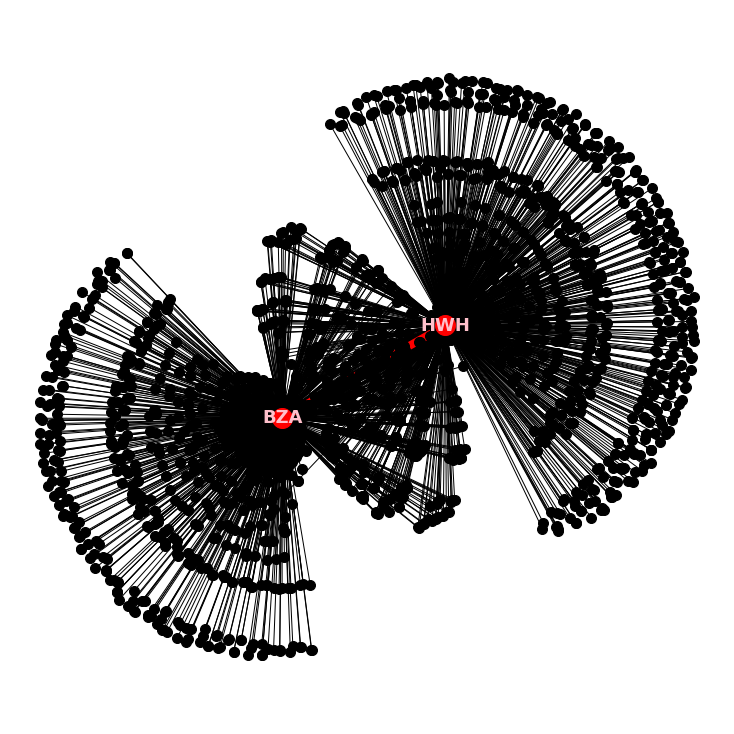

In [ ]:
# subgraph = get_subgraph(modified_railway_data, railway_network, ['DAA', 'SWV'])
subgraph = get_subgraph(modified_railway_data, railway_network, ['HWH', 'BZA'])


Building subgraph:   0%|                                                      | 0/1 [00:00<?, ?it/s]

Generating graph from train routes...


Processing trains: 100%|██████████| 7580/7580 [01:41<00:00, 74.70train/s]


Graph generation complete.


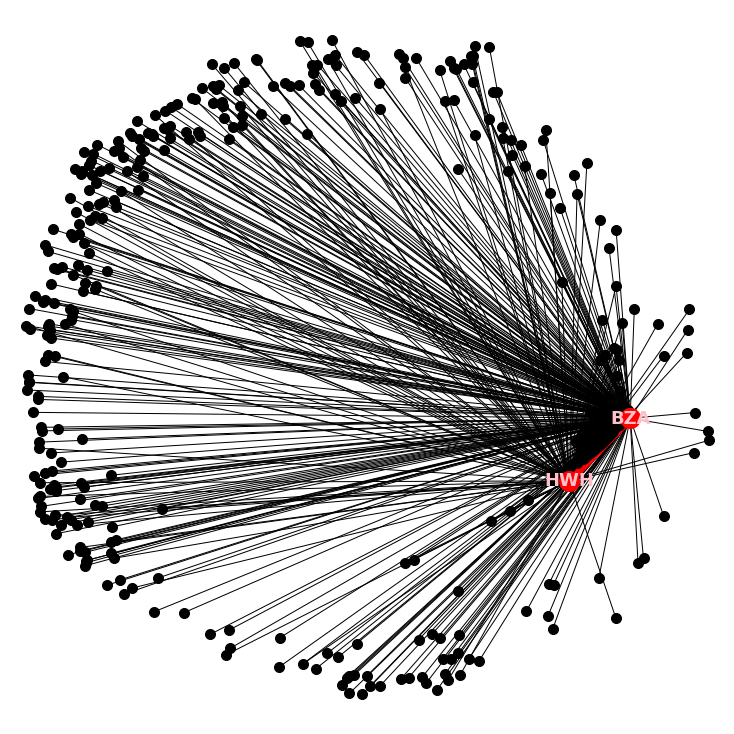

In [ ]:
subgraph = get_subgraph(modified_railway_data, railway_network, ['HWH', 'BZA'], distance_weighted=True)


Building subgraph:   0%|                                                      | 0/3 [00:00<?, ?it/s]

Generating graph from train routes...



Building subgraph:  33%|███████████████▎                              | 1/3 [01:39<03:18, 99.31s/it]

Graph generation complete.
Generating graph from train routes...



Building subgraph:  67%|██████████████████████████████▋               | 2/3 [03:18<01:39, 99.50s/it]

Graph generation complete.
Generating graph from train routes...



Processing trains: 100%|██████████| 7580/7580 [01:40<00:00, 75.55train/s]


Graph generation complete.


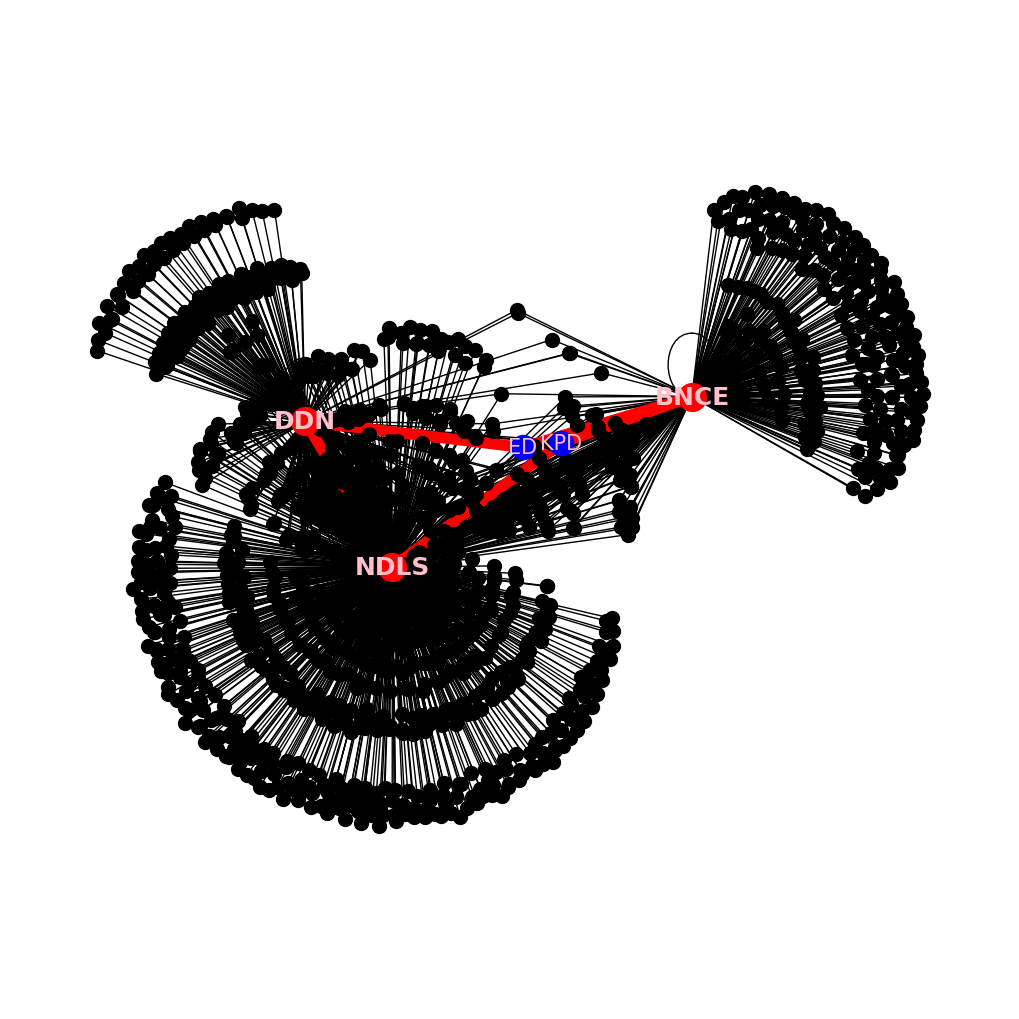

In [ ]:
subgraph = get_subgraph(modified_railway_data, railway_network, ['NDLS', 'BNCE', 'DDN'])


Building subgraph:   0%|                                                      | 0/3 [00:00<?, ?it/s]

Generating graph from train routes...



Building subgraph:  33%|███████████████                              | 1/3 [01:41<03:22, 101.08s/it]

Graph generation complete.
Generating graph from train routes...



Building subgraph:  67%|██████████████████████████████               | 2/3 [03:21<01:40, 100.86s/it]

Graph generation complete.
Generating graph from train routes...



Processing trains: 100%|██████████| 7580/7580 [01:40<00:00, 75.53train/s]


Graph generation complete.


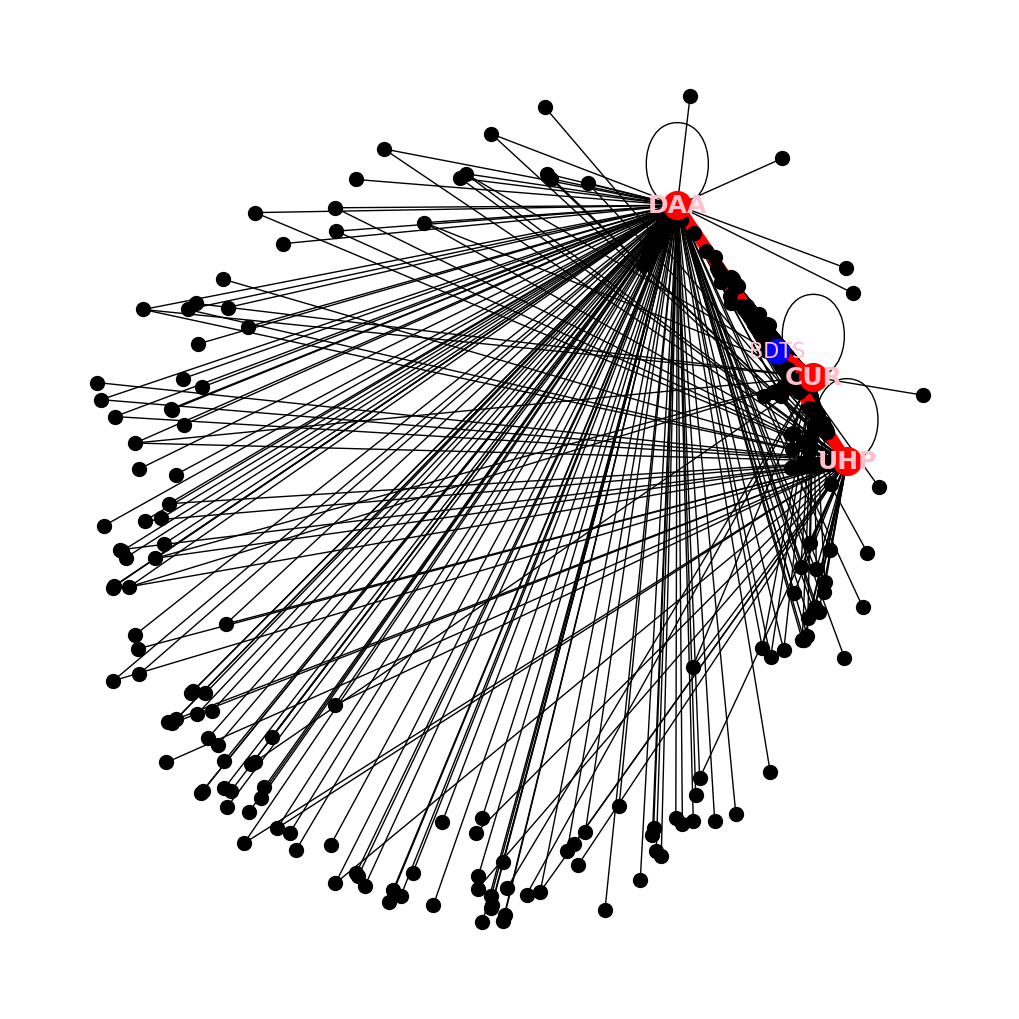

In [ ]:
subgraph = get_subgraph(modified_railway_data, railway_network, ['DAA', 'UHP', 'CUR'], distance_weighted=True)

Building subgraph:   0%|                                                      | 0/3 [00:00<?, ?it/s]

Generating graph from train routes...



Building subgraph:  33%|███████████████▎                              | 1/3 [01:39<03:18, 99.48s/it]

Graph generation complete.
Generating graph from train routes...



Building subgraph:  67%|██████████████████████████████▋               | 2/3 [03:19<01:39, 99.63s/it]

Graph generation complete.
Generating graph from train routes...



Processing trains: 100%|██████████| 7580/7580 [01:38<00:00, 76.86train/s]


Graph generation complete.


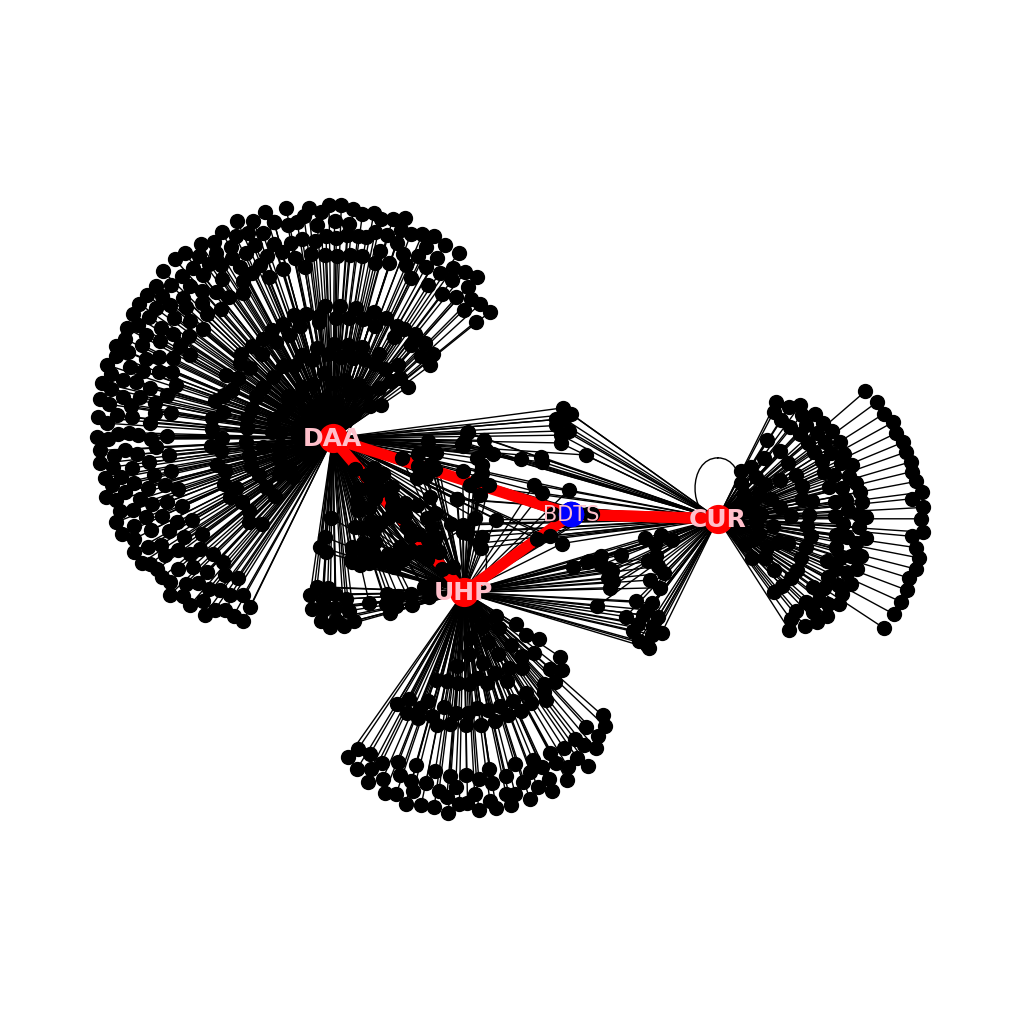

In [ ]:
subgraph = get_subgraph(modified_railway_data, railway_network, ['DAA', 'UHP', 'CUR'])


Building subgraph:   0%|                                                      | 0/3 [00:00<?, ?it/s]

Generating graph from train routes...



Building subgraph:  33%|███████████████▎                              | 1/3 [01:38<03:17, 98.79s/it]

Graph generation complete.
Generating graph from train routes...



Building subgraph:  67%|██████████████████████████████▋               | 2/3 [03:16<01:38, 98.27s/it]

Graph generation complete.
Generating graph from train routes...



Processing trains: 100%|██████████| 7580/7580 [01:37<00:00, 77.68train/s]


Graph generation complete.


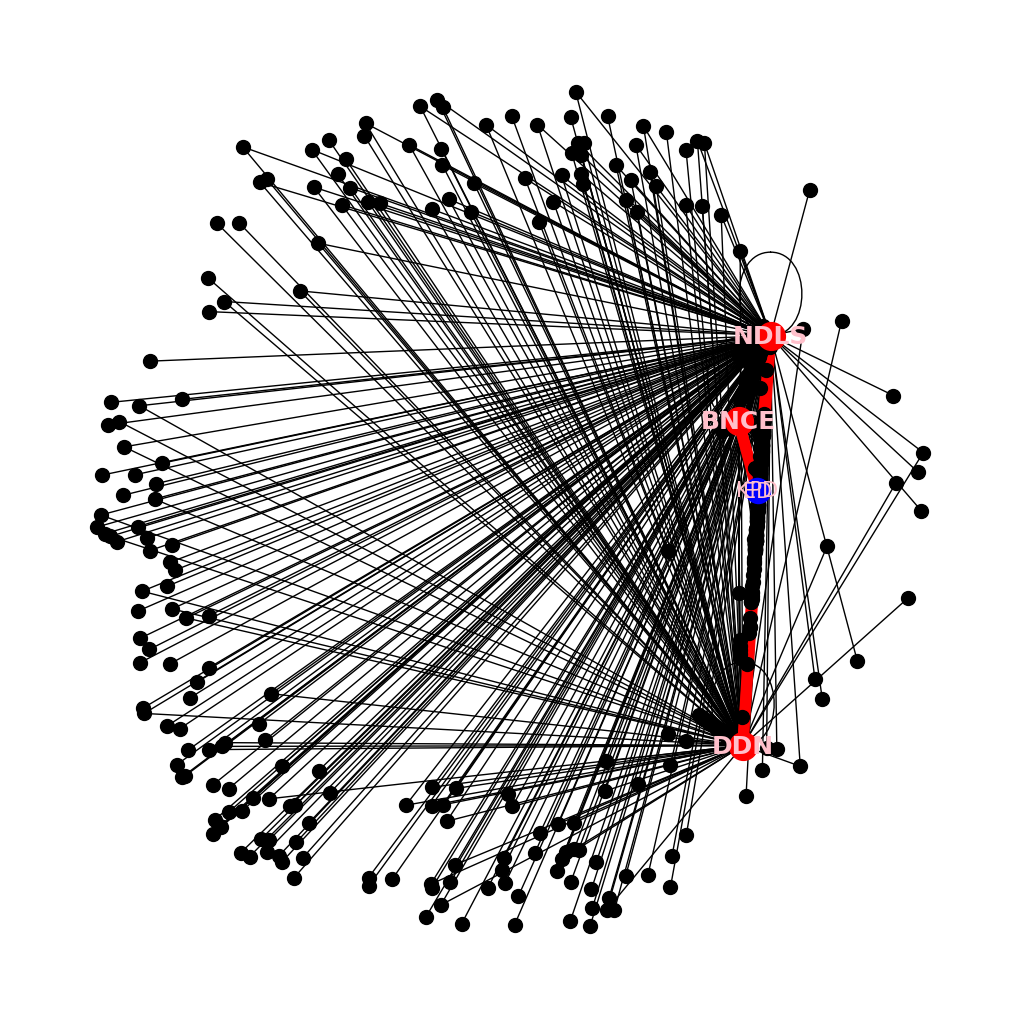

In [ ]:
subgraph = get_subgraph(modified_railway_data, railway_network, ['NDLS', 'BNCE', 'DDN'], distance_weighted=True)


In [ ]:
import operator
def compute_centrality(Railway_Network, description, railway_data):
  centrality = {}
  if description == "Degree":
    centrality = nx.degree_centrality(Railway_Network)
  elif description == "Betweenness":
    centrality = nx.betweenness_centrality(Railway_Network)
  elif description == "Closeness":
    centrality = nx.closeness_centrality(Railway_Network)
  elif description == "Eigen Vector":
    centrality = nx.eigenvector_centrality_numpy(Railway_Network)
  else:
    print("Incorrect input centrality measure")
    
  centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
  stations = []
  for item in centrality:
    station_code = item[0]
    stations.append((railway_data.loc[railway_data['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))
  
  return stations

In [ ]:
DegreeCentrality_stations = compute_centrality(railway_network, "Degree", railway_data)
print("Top Stations in the Indian Railway System acc to the Degree Centrality:\n\n \tSTATION NAME\t\t BETWEENNESS CENTRALITY")
for item in DegreeCentrality_stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the European Railway System acc to the Degree Centrality:

 	STATION NAME		 BETWEENNESS CENTRALITY
	 HOWRAH JN. 		 0.30211146575006137
	 VIJAYWADA JN 		 0.2704394794991407
	 KANPUR CENTR 		 0.263810459121041
	 VARANASI JN. 		 0.25767247728946724
	 GHAZIABAD JN 		 0.25202553400441935
	 KALYAN JN 		 0.24797446599558065
	 ITARSI 		 0.24441443653326786
	 LUCKNOW JN. 		 0.243677878713479
	 AHMEDABAD 		 0.23852197397495703
	 MATHURA JN. 		 0.2363123005155905


In [ ]:
BetweennessCentrality_stations = compute_centrality(railway_network, "Betweenness", railway_data)
print("Top stations in the Indian Railway System acc to the Betweenness Centrality:\n\n \tSTATION NAME\t\t BETWEENNESS CENTRALITY")
for item in BetweennessCentrality_stations:
  print("\t",item[0],"\t\t",item[1])

Top stations in the Indian Railway System acc to the Betweenness Centrality:

 	STATION NAME		 BETWEENNESS CENTRALITY
	 HOWRAH JN. 		 0.03406351792928565
	 SEALDAH 		 0.021795409939440933
	 KANPUR CENTR 		 0.020930718809083173
	 VIJAYWADA JN 		 0.015177400281457004
	 AHMEDABAD 		 0.014301664879802252
	 YESVANTPUR J 		 0.014256569821548529
	 VADODARA JN. 		 0.012967968029171826
	 VARANASI JN. 		 0.012623744668081234
	 KOLKATA 		 0.011898350401287686
	 PILIBHIT JN. 		 0.01184539309233258


In [ ]:
ClosenessCentrality_stations = compute_centrality(railway_network, "Closeness", railway_data)
print("Top stations in the Indian Railway System acc to the Closeness Centrality:\n\n \tSTATION NAME\t\t BETWEENNESS CENTRALITY")
for item in ClosenessCentrality_stations:
  print("\t",item[0],"\t\t",item[1])

Top stations in the Indian Railway System acc to the Closeness Centrality:

 	STATION NAME		 BETWEENNESS CENTRALITY
	 HOWRAH JN. 		 0.5124082033874587
	 AHMEDABAD 		 0.5107660799308908
	 VADODARA JN. 		 0.5063522924820026
	 KANPUR CENTR 		 0.5062879529276847
	 VARANASI JN. 		 0.5052287059583946
	 NEW DELHI 		 0.5051966767517281
	 KALYAN JN 		 0.5036640360941574
	 MUGHAL SARAI 		 0.5035049206471066
	 VIJAYWADA JN 		 0.5021406666088064
	 ITARSI 		 0.4998101090743702


In [ ]:
EigenVectorCentrality_stations = compute_centrality(railway_network, "Eigen Vector", railway_data)
print("Top stations in the Indian Railway System acc to the Eigen Vector Centrality:\n\n \tSTATION NAME\t\t BETWEENNESS CENTRALITY")
for item in EigenVectorCentrality_stations:
  print("\t",item[0],"\t\t",item[1])

Top stations in the Indian Railway System acc to the Eigen Vector Centrality:

 	STATION NAME		 BETWEENNESS CENTRALITY
	 VARANASI JN. 		 0.07072646825994844
	 HOWRAH JN. 		 0.0696564673531263
	 KANPUR CENTR 		 0.06676069453032213
	 ITARSI 		 0.06674728443587287
	 NEW DELHI 		 0.06624320025503437
	 LUDHIANA JN. 		 0.06593208791866617
	 MATHURA JN. 		 0.06569071466478023
	 KALYAN JN 		 0.06527068019550918
	 PATNA JN. 		 0.06473312502358503
	 MUGHAL SARAI 		 0.06457963445769374


In [ ]:
print('Number of trains:', len(np.unique(modified_railway_data['Train Name'].astype('str'))))
print('Number of stations:', len(np.unique(modified_railway_data['Station Code'].astype('str'))))

Number of trains: 7580
Number of stations: 8147


In [9]:
distances = modified_railway_data['Distance'].astype('int')
longest_route_df = modified_railway_data[modified_railway_data['Distance']==str(distances.max())]
distances = distances.replace(0, distances.max())
shortest_route_df = modified_railway_data[modified_railway_data['Distance']==str(distances.min())]
print('Longest train route:', distances.max(), 'km. Train = ', longest_route_df['Train No'].iloc[0], longest_route_df['Train Name'].iloc[0], '. Starting station: ', longest_route_df['Source Station Name'].iloc[0], '. Ending Station: ', longest_route_df['Destination Station Name'].iloc[0])
print('Shortest train route:', distances.min(), 'km. Train = ', shortest_route_df['Train No'].iloc[0], shortest_route_df['Train Name'].iloc[0], '. Starting station: ', shortest_route_df['Source Station Name'].iloc[0], '. Ending Station: ', shortest_route_df['Destination Station Name'].iloc[0])

trains = np.unique(modified_railway_data['Train Name'].astype('str'))
max_distance_between_stations = 0
min_distance_between_stations = distances.max()
min_train_name = ''
max_train_name = ''
average_train_route_distance = 0
average_distance_between_stops = 0
# iterate over all trains
for train_name in trains:
  train_route = modified_railway_data.loc[modified_railway_data['Train Name'] == train_name]
  station_distances = train_route['Distance'].to_list()
  for station_itr in range(len(station_distances)-1):
    distance = int(station_distances[station_itr+1]) - int(station_distances[station_itr])
    if distance < min_distance_between_stations and distance > 0:
      min_distance_between_stations = distance
      min_train_name = train_name
    if distance > max_distance_between_stations:
      max_distance_between_stations = distance
      max_train_name = train_name
  average_train_route_distance+=int(station_distances[-1])

average_distance_between_stops = average_train_route_distance
average_train_route_distance/=len(trains)
average_distance_between_stops/=modified_railway_data['Station Code'].shape[0]
print("Maximum distance between any two consecutive stations:", max_distance_between_stations, ' km with train', max_train_name)
print("Minimum distance between any two consecutive stations:", min_distance_between_stations, ' km with train', min_train_name)
print("Average total train route distance:", round(average_train_route_distance, 2), 'km')
print("Average distance between consecutive stops", round(average_distance_between_stops, 2), 'km')
  

Longest train route: 4260 km. Train =  15905 CAPE - DBRG . Starting station:  KANNIYAKUMARI . Ending Station:  DIBRUGARH
Shortest train route: 1 km. Train =  3308 PLJE-SZE MEM . Starting station:  PHULWARTANR . Ending Station:  SONARDIH
Maximum distance between any two consecutive stations: 1301  km with train RSD-PJP BSF
Minimum distance between any two consecutive stations: 1  km with train  LGL KNJ EMU
Average total train route distance: 439.7 km
Average distance between consecutive stops 17.91 km


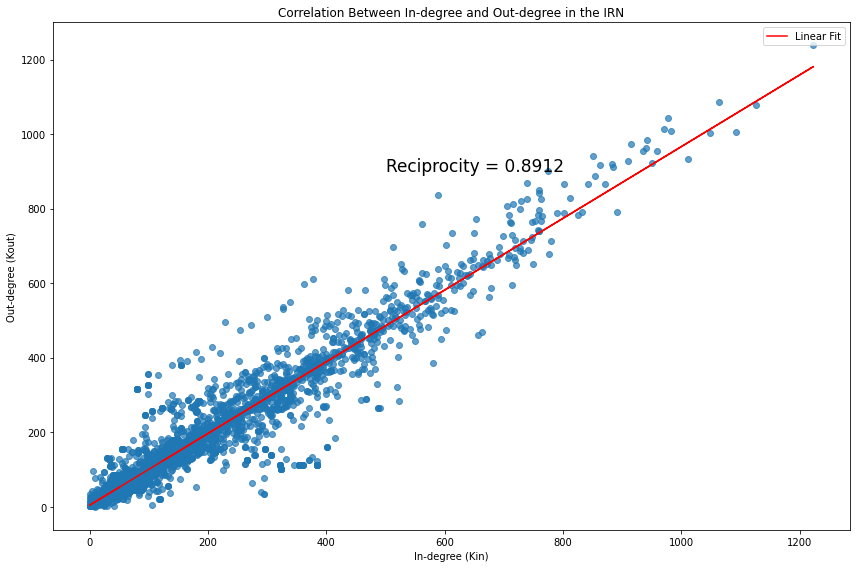

In [ ]:
# import collections
# indegree_sequence = [d for n, d in railway_network.in_degree()]
# #print("Indegree Distribution", Railway_Network.in_degree())
# indegreeCount = collections.Counter(indegree_sequence)


# outdegree_sequence = [d for n, d in railway_network.out_degree()]
# #print("Outdegree Distribution", Railway_Network.out_degree())
# outdegreeCount = collections.Counter(outdegree_sequence)

# plt.figure(figsize=(11, 6.5))
# plt.scatter(indegree_sequence, outdegree_sequence)
# plt.xlabel("Kin")
# plt.ylabel("Kout")
# plt.text(500, 900, "R =" + str(round(nx.reciprocity(railway_network), 4)), fontsize=15)

# m, b = np.polyfit(np.array(indegree_sequence), np.array(outdegree_sequence), 1)
# plt.plot(np.array(indegree_sequence), m*np.array(indegree_sequence) + b, color = 'r')
# plt.title("The correlation between Kin and Kout in the IRN")

# plt.show()

import matplotlib.pyplot as plt
import collections
import numpy as np
import networkx as nx

# Extract in-degree and out-degree for all nodes
in_degrees = [deg for _, deg in railway_network.in_degree()]
out_degrees = [deg for _, deg in railway_network.out_degree()]

# Count frequency of each degree value
in_deg_freq = collections.Counter(in_degrees)
out_deg_freq = collections.Counter(out_degrees)

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(12, 8))
plt.scatter(in_degrees, out_degrees, alpha=0.7)

# Label axes
plt.xlabel("In-degree (Kin)")
plt.ylabel("Out-degree (Kout)")

# Calculate and display reciprocity of the graph
reciprocal_ratio = round(nx.reciprocity(railway_network), 4)
plt.text(500, 900, f"Reciprocity = {reciprocal_ratio}", fontsize=17)

# Fit and plot a linear regression line for Kin vs Kout
slope, intercept = np.polyfit(in_degrees, out_degrees, 1)
regression_line = slope * np.array(in_degrees) + intercept
plt.plot(in_degrees, regression_line, color='red', label='Linear Fit')

plt.title("Correlation Between In-degree and Out-degree in the IRN")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
G_Undirected = railway_network.to_undirected()
degrees = [d for n, d in G_Undirected.degree()]

## 1. Basic Statistics
print("=== Degree Analysis ===")
print(f"Number of nodes: {G_Undirected.number_of_nodes()}")
print(f"Number of edges: {G_Undirected.number_of_edges()}")
print(f"Average degree: {np.mean(degrees):.2f}")
print(f"Median degree: {np.median(degrees):.2f}")
print(f"Maximum degree: {max(degrees)}")
print(f"Minimum degree: {min(degrees)}")
print(f"Density: {nx.density(G_Undirected):.4f}")


=== Degree Analysis ===
Number of nodes: 8147
Number of edges: 500412
Average degree: 122.85
Median degree: 68.00
Maximum degree: 1284
Minimum degree: 1
Density: 0.0151


In [ ]:
print('Num connected components in the undirected graph is:', nx.number_connected_components(G_Undirected))


Num connected components in the undirected graph is: 7


In [ ]:
def Compute_Network_Degree(indian_undirected):

    node_degree_values = indian_undirected.degree()
    weighted_node_degree_values = indian_undirected.degree(weight='weight')

    degree_values = [val for (node, val) in node_degree_values]
    weighted_degree_values = [val for (node, val) in weighted_node_degree_values]

    average_degree = np.sum(degree_values)/ len(degree_values)
    weighted_average_degree = np.sum(weighted_degree_values)/ len(weighted_degree_values)

    return average_degree, weighted_average_degree, node_degree_values, weighted_node_degree_values

average_degree, weighted_average_degree, node_degree_values, weighted_node_degree_values= Compute_Network_Degree(G_Undirected)

print("The Average Degree of the Indian Railway Network is: ", average_degree)
print("\nThe Weighted Average Degree of the Indian Railway Network is: ", weighted_average_degree)

The Average Degree of the Indian Railway Network is:  122.84571007732907

The Weighted Average Degree of the Indian Railway Network is:  1513.2014238369952


In [ ]:
print("Top 5 stations with the highest number of direct connections in the Indian Railway Network:")
top_degrees = sorted(G_Undirected.degree, key=lambda x: x[1], reverse=True)[:5]
top_degree_nodes = [node for node, _ in top_degrees]
top_degree_counts = [deg for _, deg in top_degrees]

for i in range(len(top_degree_nodes)):
    node = top_degree_nodes[i]
    station_name = modified_railway_data.loc[modified_railway_data['Station Code'] == node, 'Station Name'].iloc[0]
    print(f"{station_name}: {top_degree_counts[i]} connections")

print("\nTop 5 stations with the highest weighted connectivity (based on cumulative distance or train traffic):")
top_weighted = sorted(G_Undirected.degree(weight='weight'), key=lambda x: x[1], reverse=True)[:5]
top_weighted_nodes = [node for node, _ in top_weighted]
top_weighted_counts = [weight for _, weight in top_weighted]

for i in range(len(top_weighted_nodes)):
    node = top_weighted_nodes[i]
    station_name = modified_railway_data.loc[modified_railway_data['Station Code'] == node, 'Station Name'].iloc[0]
    print(f"{station_name}: weighted degree = {top_weighted_counts[i]}")


Top 5 stations with the highest number of direct connections in the Indian Railway Network:
HOWRAH JN.: 1284 connections
VIJAYWADA JN: 1171 connections
VARANASI JN.: 1124 connections
KANPUR CENTR: 1119 connections
LUCKNOW JN.: 1104 connections

Top 5 stations with the highest weighted connectivity (based on cumulative distance or train traffic):
CHENNAI BEAC: weighted degree = 289635
TAMBARAM: weighted degree = 231587
PALLAVARAM: weighted degree = 195255
ST. THOMAS M: weighted degree = 194981
CHENNAI EGMO: weighted degree = 194449


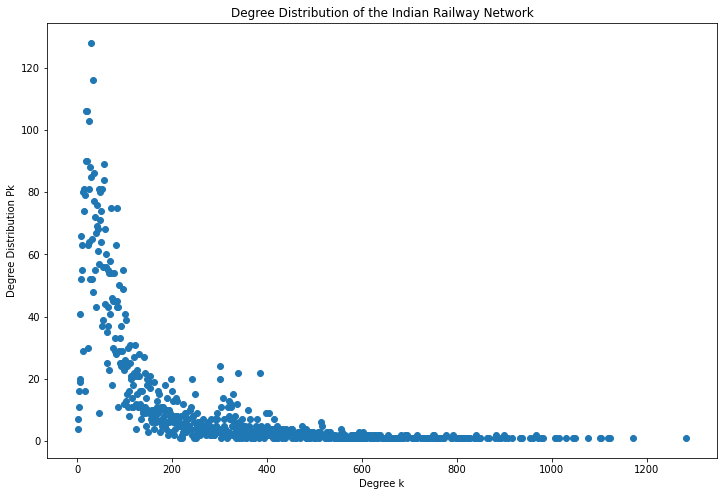

In [ ]:
def Compute_Degree_Distribution(indian_undirected):

    degree_sequence = sorted([d for n, d in G_Undirected.degree()])
    degreeCount = collections.Counter(degree_sequence)

    degree, count = zip(*degreeCount.items())

    plt.figure(figsize=(12, 8))
    plt.scatter(degree, count)

    plt.xlabel("Degree k")
    plt.ylabel("Degree Distribution Pk")

    plt.title("Degree Distribution of the Indian Railway Network")

    plt.show()
Compute_Degree_Distribution(G_Undirected)

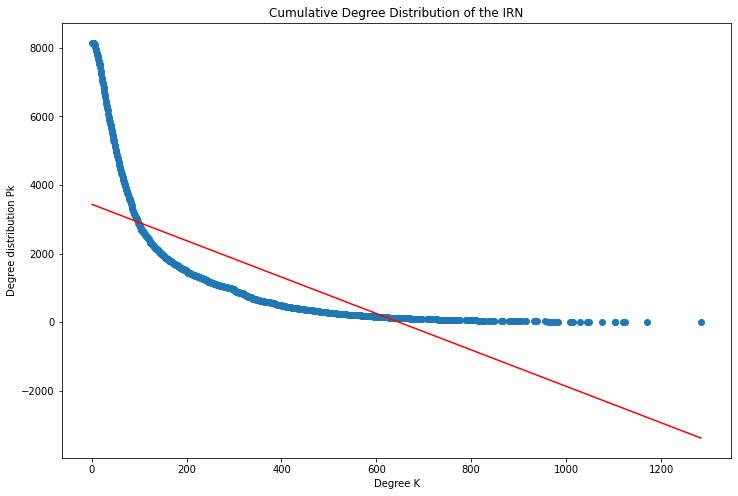

In [ ]:
def Compute_Cumulative_Degree_Distribution(indian_undirected):

    degree_sequence = sorted([d for n, d in indian_undirected.degree()])
    degreeCount = collections.Counter(degree_sequence)

    degree, count = zip(*degreeCount.items())

    cumulative_count = np.cumsum(count[::-1])[::-1] 

    plt.figure(figsize=(12, 8))
    plt.scatter(degree, cumulative_count)

    plt.xlabel("Degree K")
    plt.ylabel("Degree distribution Pk")

    m, b = np.polyfit(np.array(degree), np.array(cumulative_count), 1)
    plt.plot(np.array(degree), m*np.array(degree) + b, color = 'r')

    plt.title("Cumulative Degree Distribution of the IRN")

    plt.show()
Compute_Cumulative_Degree_Distribution(G_Undirected)

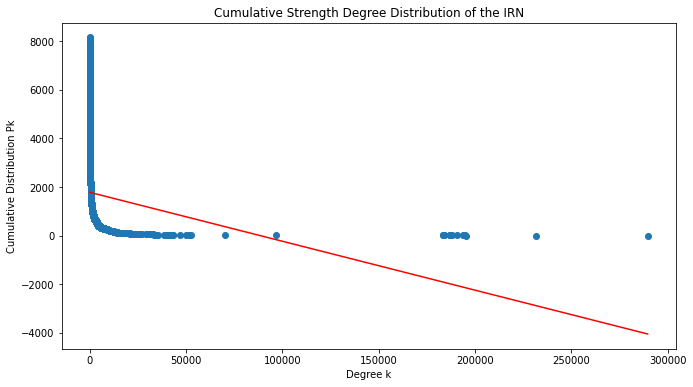

The Clustering Coefficent of the Graph:  0.7635363552259165


In [13]:
import collections
def Compute_Cumulative_Strength_Distribution(indian_undirected):

    degree_sequence = sorted([d for n, d in indian_undirected.degree(weight = 'weight')])
    degreeCount = collections.Counter(degree_sequence)

    degree, count = zip(*degreeCount.items())

    cumulative_count = np.cumsum(count[::-1])[::-1] 

    plt.figure(figsize=(11, 6))
    plt.scatter(degree, cumulative_count)

    plt.xlabel("Degree k")
    plt.ylabel("Cumulative Distribution Pk")

    m, b = np.polyfit(np.array(degree), np.array(cumulative_count), 1)
    plt.plot(np.array(degree), m*np.array(degree) + b, color = 'r')

    plt.title("Cumulative Strength Degree Distribution of the IRN")

    plt.show()

Compute_Cumulative_Strength_Distribution(G_Undirected)
Clustering_Coefficient = nx.average_clustering(G_Undirected)
print("The Clustering Coefficent of the Graph: ", Clustering_Coefficient)

In [ ]:

def Compute_Clustering_Coefficient(indian_undirected):

    node_clustering_values = nx.clustering(indian_undirected)

    node_degree_values = indian_undirected.degree()
    unique_degrees = list(set([y for (x,y) in node_degree_values]))

    Degree_Clustering = {}

    for degree in unique_degrees:
        nodes_kdegree = [x for (x, y) in node_degree_values if y == degree]
        count_nodes_kdegree = len(nodes_kdegree)

        clustering_sum  = 0
        for node in nodes_kdegree:
            clustering_sum = clustering_sum + node_clustering_values[node]
        
        average_clustering = clustering_sum / count_nodes_kdegree
        Degree_Clustering[degree] = average_clustering

    return Degree_Clustering
Degree_Clustering = Compute_Clustering_Coefficient(G_Undirected)
Degree_Clustering

{1: 0.0,
 2: 0.75,
 3: 0.6363636363636364,
 4: 0.9895833333333334,
 5: 0.9842105263157894,
 6: 0.9916666666666666,
 7: 1.0,
 8: 0.9958791208791209,
 9: 1.0,
 10: 1.0,
 11: 0.9810405643738976,
 12: 0.9791013584117031,
 13: 0.9877272727272729,
 14: 0.9924129924129924,
 15: 0.9967304300637634,
 16: 1.0,
 17: 0.9909318157642804,
 18: 0.9873504747811074,
 19: 0.975797882505829,
 20: 0.9835802973953567,
 21: 0.9921841641139886,
 22: 0.9551627987718214,
 23: 0.9365167199949808,
 24: 0.9556817310440497,
 25: 0.9666800477602108,
 26: 0.9756382115141087,
 27: 0.9712095312095311,
 28: 0.9360834037757115,
 29: 0.9644335699023197,
 30: 0.9663764662953304,
 31: 0.9491264204834836,
 32: 0.9277346624454519,
 33: 0.8840371965623985,
 34: 0.9454532938162624,
 35: 0.9207522755402372,
 36: 0.9133018496654859,
 37: 0.9474352153273724,
 38: 0.9350937950937945,
 39: 0.8861950642856395,
 40: 0.8923798503924192,
 41: 0.892630810923494,
 42: 0.9090065101778838,
 43: 0.9248506492784296,
 44: 0.872261162986733,
 

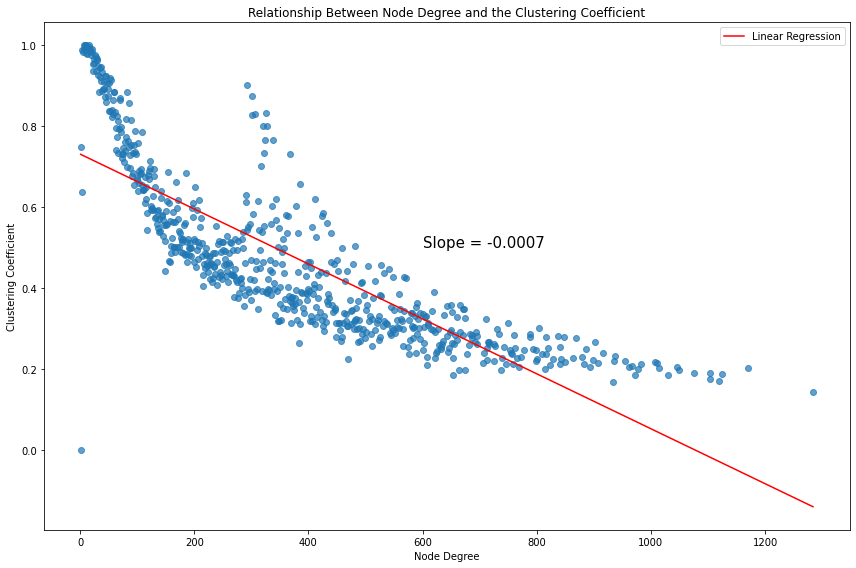

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting: degree vs clustering coefficient
degree_values = list(Degree_Clustering.keys())
clustering_scores = list(Degree_Clustering.values())

# Initialize figure
plt.figure(figsize=(12, 8))
plt.scatter(degree_values, clustering_scores, alpha=0.7)

# Axis labels
plt.xlabel("Node Degree")
plt.ylabel("Clustering Coefficient")

# Fit and overlay a linear trend line
slope, intercept = np.polyfit(degree_values, clustering_scores, 1)
trend_line = slope * np.array(degree_values) + intercept
plt.plot(degree_values, trend_line, color='red', label='Linear Regression')

# Display the slope on the plot
plt.text(600, 0.5, f"Slope = {round(slope, 4)}", fontsize=15)

# Plot title
plt.title("Relationship Between Node Degree and the Clustering Coefficient")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def analyze_path_length_of_IRN(indian_undirected):

    shortest_path_lengths = list(nx.shortest_path_length(indian_undirected))
    Path_Lengths = {}
    
    for node_path_lengths in tqdm(shortest_path_lengths):
  
        source_station = node_path_lengths[0]
        destination_stations = node_path_lengths[1]

        for station in destination_stations:
            path = (station, source_station)
            if(path not in Path_Lengths):
                Path_Lengths[(source_station, station)] =  destination_stations[station]
    
    return Path_Lengths
Path_length = analyze_path_length_of_IRN(G_Undirected)
# print(Path_length)

100%|██████████| 8147/8147 [00:58<00:00, 138.73it/s]


In [ ]:
def analyze_path_length_distribution_of_IRN(Path_Lengths):

    path_length_sequence = Path_Lengths.values()
    path_lengthCount = collections.Counter(path_length_sequence)

    path_length, count = zip(*path_lengthCount.items())

    return path_length, count
shortest_path_lengths, shortest_path_length_values = analyze_path_length_distribution_of_IRN(Path_length)
Path_length_distribution = {shortest_path_lengths[i]: shortest_path_length_values[i] for i in range(len(shortest_path_lengths))}
     

{0: 8147, 1: 495316, 2: 7114945, 3: 21252418, 4: 3044950, 5: 394421, 6: 154422, 7: 13244, 8: 583, 9: 186, 10: 18} 



Text(0.5, 1.0, 'Logplot of the Path Length Distribution')

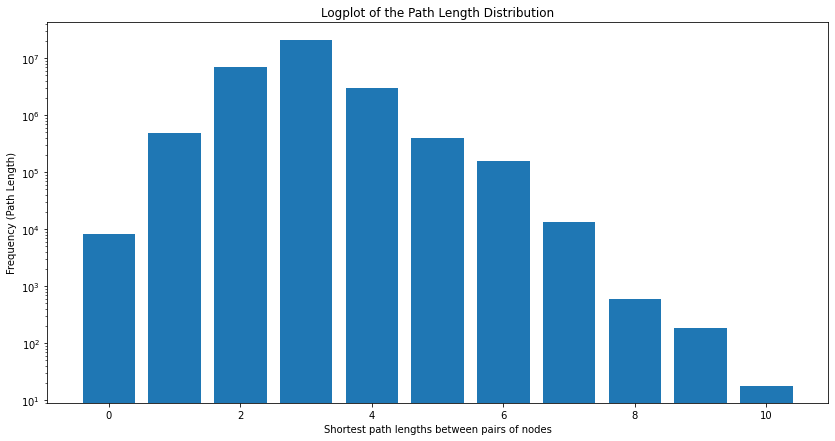

In [ ]:
print(Path_length_distribution, "\n")

plt.figure(figsize=(14, 7))
plt.bar(Path_length_distribution.keys(), Path_length_distribution.values())
plt.xlabel("Shortest path lengths between pairs of nodes")
plt.ylabel("Frequency (Path Length)")
plt.yscale('log')

plt.title("Logplot of the Path Length Distribution")

In [ ]:
import numpy as np
import networkx as nx

# Initialize accumulators for statistics
total_path_length = 0
diameters = []
path_lengths = []
component_count = 0

# Iterate over each connected component of the undirected graph
for component in tqdm(G_Undirected.subgraph(nodes).copy() for nodes in nx.connected_components(G_Undirected)):
    if nx.average_shortest_path_length(component) > 0:
        component_count += 1
        total_path_length += nx.average_shortest_path_length(component)
    diameters.append(nx.diameter(component))
    path_lengths.append(nx.average_shortest_path_length(component))

# Compute average values
avg_path_length = total_path_length / component_count
avg_diameter = np.mean(diameters)

# Output the results
print("Mean shortest path length across Indian Railway Network:", avg_path_length)
print("Mean diameter of connected components in the network:", avg_diameter)


0it [00:00, ?it/s]

7it [19:14, 164.98s/it] 

Mean shortest path length across Indian Railway Network: 1.3796888795757478
Mean diameter of connected components in the network: 2.857142857142857


In [ ]:
import networkx as nx

# Generate a Barabási–Albert scale-free network
ba_graph = nx.barabasi_albert_graph(n=8147, m=30)

# Calculate clustering coefficient and path length
ba_clustering = nx.average_clustering(ba_graph)
ba_path_length = nx.average_shortest_path_length(ba_graph)

# Display results
print("Barabási–Albert Model - Avg. Clustering Coefficient:", ba_clustering)
print("Barabási–Albert Model - Avg. Shortest Path Length:", ba_path_length)

# ----------------------------

# Generate an Erdős–Rényi random graph with similar size and density
# p is chosen so that expected number of edges is roughly equal to BA model
# BA model has ~n*m edges, so p ≈ 2*m / (n - 1)
n = 8147
m = 30
p = 2 * m / (n - 1)
er_graph = nx.erdos_renyi_graph(n=n, p=p)

# Compute metrics for the ER model
er_clustering = nx.average_clustering(er_graph)
er_path_length = nx.average_shortest_path_length(er_graph)

# Display results
print("Erdős–Rényi Model - Avg. Clustering Coefficient:", er_clustering)
print("Erdős–Rényi Model - Avg. Shortest Path Length:", er_path_length)


Barabási–Albert Model - Avg. Clustering Coefficient: 0.02736096103553356
Barabási–Albert Model - Avg. Shortest Path Length: 2.5331992414970306
Erdős–Rényi Model - Avg. Clustering Coefficient: 0.007374898133090904
Erdős–Rényi Model - Avg. Shortest Path Length: 2.629876124421465


<!-- Degree Correlation -->

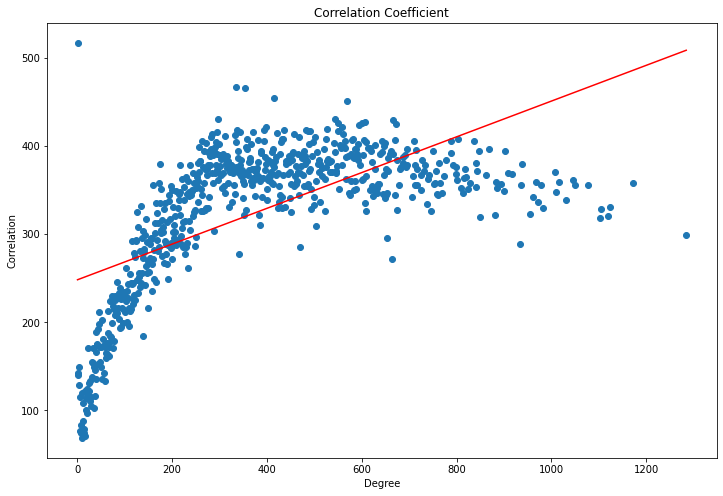

In [ ]:
def compute_degree_correlation(undirected_graph):
    # Get the degree of all nodes
    node_degrees = dict(undirected_graph.degree())
    unique_k_values = set(node_degrees.values())
    degree_correlation = {}

    for k in unique_k_values:
        # Find nodes with degree exactly equal to k
        nodes_with_k = [node for node, deg in node_degrees.items() if deg == k]
        if not nodes_with_k:
            continue

        # Sum of average neighbor degrees for all such nodes
        average_neighbor_degree_sum = 0

        for node in nodes_with_k:
            neighbors = list(undirected_graph.neighbors(node))
            if neighbors:
                neighbor_degrees = [node_degrees[neighbor] for neighbor in neighbors]
                avg_neighbor_deg = sum(neighbor_degrees) / len(neighbor_degrees)
            else:
                avg_neighbor_deg = 0
            average_neighbor_degree_sum += avg_neighbor_deg

        # Final correlation value for current degree k
        degree_correlation[k] = average_neighbor_degree_sum / len(nodes_with_k)

    return degree_correlation

Degree_Correlation = compute_degree_correlation(G_Undirected)
Degree_Values = (list(Degree_Correlation.keys()))
Degree_Correlation_Values = (list(Degree_Correlation.values()))

plt.figure(figsize=(12, 8))

plt.scatter(Degree_Values, Degree_Correlation_Values)

plt.xlabel("Degree")  
plt.ylabel("Correlation")

m, b = np.polyfit(np.array(Degree_Values), np.array(Degree_Correlation_Values), 1)
plt.plot(np.array(Degree_Values), m*np.array(Degree_Values) + b, color = 'r')

plt.title("Correlation Coefficient")

plt.show()


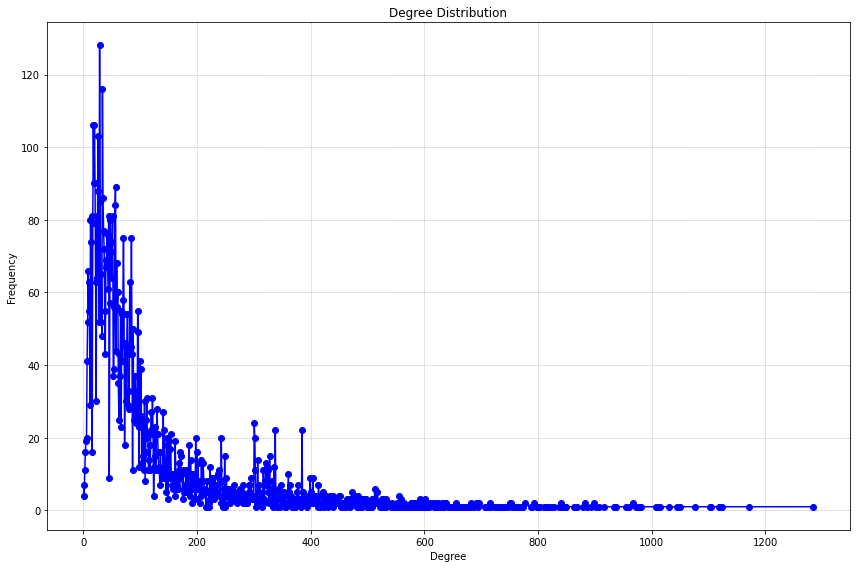

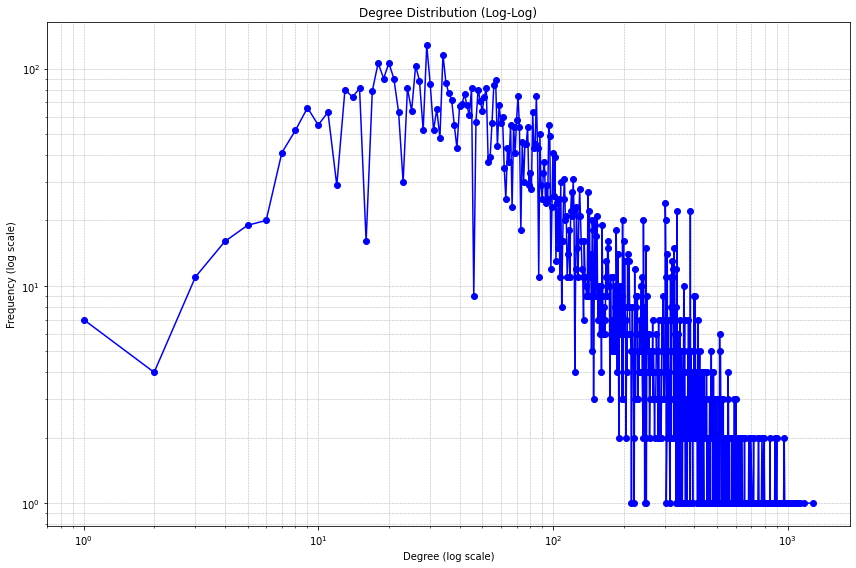

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_degree_distribution(graph, loglog=False, title="Degree Distribution"):
    """
    Plots the degree distribution of a given graph.

    Parameters:
    - graph: NetworkX graph (can be directed or undirected)
    - loglog: If True, plots the degree distribution on a log-log scale
    - title: Title of the plot
    """

    # Get degree of all nodes
    if graph.is_directed():
        degrees = [deg for _, deg in graph.degree()]
    else:
        degrees = list(dict(graph.degree()).values())

    # Count frequency of each degree
    degree_counts = dict()
    for deg in degrees:
        degree_counts[deg] = degree_counts.get(deg, 0) + 1

    # Sort the data for plotting
    x = sorted(degree_counts.keys())
    y = [degree_counts[k] for k in x]

    # Plot the degree distribution
    plt.figure(figsize=(12, 8))
    if loglog:
        plt.loglog(x, y, 'bo-')
        plt.xlabel("Degree (log scale)")
        plt.ylabel("Frequency (log scale)")
        plt.title(f"{title} (Log-Log)")
    else:
        plt.plot(x, y, 'bo-')
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.title(title)

    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_degree_distribution(G_Undirected, loglog=False)
plot_degree_distribution(G_Undirected.to_undirected(), loglog=True)

<!-- Assortativity Coefficient -->

In [ ]:
assortativity_coefficient = nx.degree_pearson_correlation_coefficient(railway_network)
print("The Assotativity Coefficient of the Indian Railway Network is: ", assortativity_coefficient)

The Assotativity Coefficient of the Indian Railway Network is:  0.24250767571456786


In [ ]:
import networkx as nx
import numpy as np
import random
from collections import Counter, defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
import time
import pandas as pd

def get_triad_id(G, nodes):
    """
    Generate a canonical ID for a 3-node subgraph based on its adjacency pattern.
    This implementation is more efficient for large networks.
    """
    # Create a 3x3 adjacency matrix
    adj = np.zeros((3, 3), dtype=int)
    
    # Map nodes to indices 0, 1, 2
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    # Fill the adjacency matrix
    for u, v in G.subgraph(nodes).edges():
        adj[node_to_idx[u]][node_to_idx[v]] = 1
    
    # Return as a hashable tuple
    return tuple(map(tuple, adj))

def enumerate_connected_triads(G):
    """
    Enumerate all connected 3-node subgraphs.
    This approach is more memory-efficient for large networks.
    """
    triad_counts = Counter()
    print("Enumerating connected triads...")
    
    # Process in batches of nodes to avoid memory issues
    nodes = list(G.nodes())
    nodes_count = len(nodes)
    batch_size = min(50, nodes_count)  # Adjust batch size based on memory constraints
    
    total_processed = 0
    start_time = time.time()
    
    for i in range(0, nodes_count, batch_size):
        batch_nodes = nodes[i:min(i+batch_size, nodes_count)]
        
        # Process triplets involving at least one node from this batch
        for node1 in batch_nodes:
            neighbors = set(G.successors(node1)).union(set(G.predecessors(node1)))
            neighbors = list(neighbors)
            
            # Consider triplets with node1 and two of its neighbors
            for j, node2 in enumerate(neighbors):
                for node3 in neighbors[j+1:]:
                    triplet = (node1, node2, node3)
                    subgraph = G.subgraph(triplet)
                    
                    if nx.is_weakly_connected(subgraph):
                        # Get canonical ID and increment count
                        triad_id = get_triad_id(G, triplet)
                        triad_counts[triad_id] += 1
        
        total_processed += len(batch_nodes)
        elapsed = time.time() - start_time
        print(f"Processed {total_processed}/{nodes_count} nodes in {elapsed:.2f} seconds")
    
    # Divide by 6 because each triad is counted multiple times
    # (once for each node in the triad)
    for triad_id in triad_counts:
        triad_counts[triad_id] = triad_counts[triad_id] // 6
    
    print(f"Found {len(triad_counts)} unique connected triad patterns")
    return triad_counts

def generate_random_graph(G, preserving_method='configuration'):
    """
    Generate a random graph with the same degree sequence as G.
    """
    if preserving_method == 'configuration':
        # Configuration model preserves degree sequence
        in_degrees = [d for n, d in G.in_degree()]
        out_degrees = [d for n, d in G.out_degree()]
        
        try:
            R = nx.directed_configuration_model(in_degrees, out_degrees)
            R = nx.DiGraph(R)  # Remove parallel edges
            R.remove_edges_from(nx.selfloop_edges(R))  # Remove self-loops
        except Exception as e:
            print(f"Configuration model failed: {e}. Using edge swapping instead.")
            R = generate_random_graph(G, 'edge_swap')
    else:
        # Edge swapping preserves exact degree sequence
        R = G.copy()
        try:
            n_swaps = min(10 * len(G.edges()), 100000)  # Cap the number of swaps
            nx.algorithms.swap.directed_edge_swap(R, nswaps=n_swaps, max_tries=n_swaps*10)
        except Exception as e:
            print(f"Edge swapping warning: {e}")
    
    return R

def calculate_motif_significance(G, num_random=10):
    """
    Calculate the significance of each triad motif using Z-scores.
    """
    # Count triads in the original network
    original_counts = enumerate_connected_triads(G)
    
    # Initialize arrays for random networks
    random_counts = defaultdict(list)
    
    # Generate random networks and count triads
    print(f"Generating {num_random} random networks...")
    for i in range(num_random):
        start_time = time.time()
        R = generate_random_graph(G)
        print(f"Random network {i+1} generated in {time.time() - start_time:.2f} seconds")
        
        start_time = time.time()
        r_counts = enumerate_connected_triads(R)
        print(f"Triad counting for random network {i+1} completed in {time.time() - start_time:.2f} seconds")
        
        for triad_id, count in original_counts.items():
            random_counts[triad_id].append(r_counts.get(triad_id, 0))
    
    # Calculate z-scores
    results = []
    for triad_id, original_count in original_counts.items():
        random_values = random_counts[triad_id]
        mean_random = np.mean(random_values)
        std_random = np.std(random_values)
        
        # Calculate z-score with proper handling of zero std
        if std_random > 0:
            z_score = (original_count - mean_random) / std_random
        else:
            if original_count == mean_random:
                z_score = 0
            else:
                z_score = float('inf') if original_count > mean_random else float('-inf')
        
        results.append({
            'triad_id': triad_id,
            'original_count': original_count,
            'mean_random': mean_random,
            'std_random': std_random,
            'z_score': z_score
        })
    
    # Sort by absolute z-score
    results.sort(key=lambda x: abs(x['z_score']), reverse=True)
    return results

def visualize_triad(triad_id, index):
    """
    Visualize a 3-node subgraph from its adjacency matrix.
    """
    # Create a directed graph from the adjacency matrix
    G = nx.DiGraph()
    G.add_nodes_from([0, 1, 2])
    
    for i in range(3):
        for j in range(3):
            if triad_id[i][j] == 1:
                G.add_edge(i, j)
    
    # Position nodes in a triangle
    pos = {0: (0, 0), 1: (1, 0), 2: (0.5, 0.866)}
    
    plt.figure(figsize=(4, 4))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, 
            arrowsize=20, font_weight='bold', font_size=16)
    plt.title(f"Triad {index+1}")
    plt.savefig(f"triad_{index+1}.png")
    plt.close()

def classify_triads(results, threshold=0):
    """
    Classify triads as motifs or anti-motifs based on z-scores.
    """
    motifs = [r for r in results if r['z_score'] > threshold]
    anti_motifs = [r for r in results if r['z_score'] < -threshold]
    neutral = [r for r in results if abs(r['z_score']) <= threshold]
    
    return motifs, anti_motifs, neutral
def classify_triads_auto_threshold(results, percentile=95):
    """
    Automatically determine thresholds for motifs and anti-motifs based on Z-score distribution.
    """
    z_scores = np.array([r['z_score'] for r in results if np.isfinite(r['z_score'])])
    
    upper_thresh = np.percentile(z_scores, percentile)
    lower_thresh = np.percentile(z_scores, 100 - percentile)
    
    print(f"\nAutomatically determined Z-score thresholds:")
    print(f"Motif threshold: > {upper_thresh:.2f}, Anti-motif threshold: < {lower_thresh:.2f}")
    
    motifs = [r for r in results if r['z_score'] > upper_thresh]
    anti_motifs = [r for r in results if r['z_score'] < lower_thresh]
    neutral = [r for r in results if lower_thresh <= r['z_score'] <= upper_thresh]
    
    return motifs, anti_motifs, neutral, upper_thresh, lower_thresh

def print_results(motifs, anti_motifs, neutral, upper_thresh, lower_thresh):
    """
    Print and visualize motifs and anti-motifs based on auto-computed Z-score thresholds.
    """
    print(f"\n===== AUTOMATIC MOTIF ANALYSIS =====")
    print(f"Motif Z-score threshold: > {upper_thresh:.2f}")
    print(f"Anti-motif Z-score threshold: < {lower_thresh:.2f}")
    
    print(f"\n=== TOP {len(motifs)} MOTIFS (Z > {upper_thresh:.2f}) ===")
    for i, r in enumerate(motifs[:10]):  # visualize top 10
        print(f"Motif {i+1}: Z = {r['z_score']:.2f}, Count = {r['original_count']}, Random Mean = {r['mean_random']:.2f}")
        visualize_triad(r['triad_id'], i)

    print(f"\n=== TOP {len(anti_motifs)} ANTI-MOTIFS (Z < {lower_thresh:.2f}) ===")
    for i, r in enumerate(anti_motifs[:10]):  # visualize top 10
        print(f"Anti-motif {i+1}: Z = {r['z_score']:.2f}, Count = {r['original_count']}, Random Mean = {r['mean_random']:.2f}")
        visualize_triad(r['triad_id'], i + len(motifs))

    print(f"\nNeutral triads: {len(neutral)} (Z between {lower_thresh:.2f} and {upper_thresh:.2f})")

    # Create a summary table
    data = []
    for r in motifs:
        data.append({
            'Type': 'Motif',
            'Z-score': r['z_score'],
            'Original Count': r['original_count'],
            'Random Mean': r['mean_random'],
            'Standard Deviation': r['std_random']
        })
    for r in anti_motifs:
        data.append({
            'Type': 'Anti-motif',
            'Z-score': r['z_score'],
            'Original Count': r['original_count'],
            'Random Mean': r['mean_random'],
            'Standard Deviation': r['std_random']
        })

    df = pd.DataFrame(data)
    print("\n===== SUMMARY TABLE =====")
    print(df)
    
    # Save to CSV
    df.to_csv('motif_analysis_results.csv', index=False)
    print("Results saved to motif_analysis_results.csv")


start_time = time.time()

# Calculate motif significance
results = calculate_motif_significance(railway_network, num_random=5)  

# Classify triads
motifs, anti_motifs, neutral, upper_thresh, lower_thresh = classify_triads_auto_threshold(results)



Enumerating connected triads...
Processed 50/8147 nodes in 1593.72 seconds
Processed 100/8147 nodes in 2614.48 seconds
Processed 150/8147 nodes in 3761.80 seconds
Processed 200/8147 nodes in 5437.24 seconds
Processed 250/8147 nodes in 6457.09 seconds
Processed 300/8147 nodes in 7052.18 seconds
Processed 350/8147 nodes in 8577.03 seconds
Processed 400/8147 nodes in 9471.46 seconds


In [ ]:
import networkx as nx
import numpy as np
import random
from collections import Counter, defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
import time
import pandas as pd
import multiprocessing as mp
from functools import lru_cache
from scipy.sparse import csr_matrix

def get_triad_id_fast(G, nodes):
    """
    More efficient triad ID calculation using bitwise operations.
    """
    # Create a binary representation for fast comparison
    triad_id = 0
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    for u, v in G.subgraph(nodes).edges():
        i, j = node_to_idx[u], node_to_idx[v]
        # Set a bit for each edge
        triad_id |= (1 << (i * 3 + j))
    
    return triad_id

def process_node_batch(args):
    """
    Process a batch of nodes for parallel execution.
    """
    G, batch_nodes, all_nodes_dict = args
    local_triad_counts = Counter()
    
    # Pre-compute neighborhoods for faster access
    neighborhoods = {node: set(G.successors(node)).union(set(G.predecessors(node))) 
                    for node in batch_nodes}
    
    for node1 in batch_nodes:
        neighbors = neighborhoods[node1]
        neighbors_list = list(neighbors)
        
        # Process pairs of neighbors to form triads
        for i, node2 in enumerate(neighbors_list):
            for node3 in neighbors_list[i+1:]:
                # Early filtering: only process if this node is responsible for the triad
                if node1 <= min(node2, node3) or (node1 not in all_nodes_dict.get(node2, set()) and 
                                                  node1 not in all_nodes_dict.get(node3, set())):
                    triplet = (node1, node2, node3)
                    subgraph = G.subgraph(triplet)
                    
                    if nx.is_weakly_connected(subgraph):
                        triad_id = get_triad_id_fast(G, triplet)
                        local_triad_counts[triad_id] += 1
    
    return local_triad_counts

def enumerate_connected_triads_parallel(G, num_processes=None):
    """
    Parallelized implementation of triad enumeration.
    """
    if num_processes is None:
        num_processes = max(1, mp.cpu_count() - 1)  # Leave one core free
    
    print(f"Enumerating connected triads using {num_processes} processes...")
    
    # Create a node-to-neighborhood mapping for filtering
    all_nodes = list(G.nodes())
    all_nodes_dict = {}
    
    # Pre-compute neighborhoods to avoid redundant calculations
    for node in all_nodes:
        all_nodes_dict[node] = set(G.successors(node)).union(set(G.predecessors(node)))
    
    # Process in batches
    batch_size = max(1, len(all_nodes) // (num_processes * 4))  # Create more batches than processes
    node_batches = [all_nodes[i:i+batch_size] for i in range(0, len(all_nodes), batch_size)]
    
    # Prepare arguments for parallel processing
    args_list = [(G, batch, all_nodes_dict) for batch in node_batches]
    
    start_time = time.time()
    
    # Use multiprocessing to distribute the workload
    with mp.Pool(processes=num_processes) as pool:
        results = pool.map(process_node_batch, args_list)
    
    # Combine results from all processes
    triad_counts = Counter()
    for local_counts in results:
        triad_counts.update(local_counts)
    
    print(f"Triad enumeration completed in {time.time() - start_time:.2f} seconds")
    print(f"Found {len(triad_counts)} unique connected triad patterns")
    
    return triad_counts

def generate_random_graph(G, preserving_method='configuration'):
    """
    Generate a random graph with the same degree sequence as G.
    Optimized implementation with error handling.
    """
    if preserving_method == 'configuration':
        # Configuration model preserving degree sequence
        in_degrees = [d for n, d in G.in_degree()]
        out_degrees = [d for n, d in G.out_degree()]
        
        try:
            R = nx.directed_configuration_model(in_degrees, out_degrees, seed=random.randint(1, 10000))
            R = nx.DiGraph(R)  # Remove parallel edges
            R.remove_edges_from(nx.selfloop_edges(R))  # Remove self-loops
        except Exception as e:
            print(f"Configuration model failed: {e}. Using edge swapping instead.")
            R = generate_random_graph(G, 'edge_swap')
    else:
        # Edge swapping preserves exact degree sequence
        R = G.copy()
        try:
            n_swaps = min(10 * len(G.edges()), 100000)  # Cap the number of swaps
            nx.algorithms.swap.directed_edge_swap(R, nswaps=n_swaps, max_tries=n_swaps*10, seed=random.randint(1, 10000))
        except Exception as e:
            print(f"Edge swapping warning: {e}")
    
    return R

def calculate_motif_significance_early_stop(G, min_random=5, max_random=20, 
                                           convergence_threshold=0.1, num_processes=None):
    """
    Calculate motif significance with early stopping based on convergence.
    """
    # Count triads in the original network
    original_counts = enumerate_connected_triads_parallel(G, num_processes)
    
    # Initialize arrays for random networks
    random_counts = defaultdict(list)
    z_scores = {}
    
    # Generate random networks and count triads with early stopping
    print(f"Generating random networks (min={min_random}, max={max_random})...")
    
    for i in range(max_random):
        start_time = time.time()
        R = generate_random_graph(G)
        print(f"Random network {i+1} generated in {time.time() - start_time:.2f} seconds")
        
        start_time = time.time()
        r_counts = enumerate_connected_triads_parallel(R, num_processes)
        print(f"Triad counting for random network {i+1} completed in {time.time() - start_time:.2f} seconds")
        
        # Update random counts and recalculate z-scores
        for triad_id, original_count in original_counts.items():
            random_value = r_counts.get(triad_id, 0)
            random_counts[triad_id].append(random_value)
            
            # Calculate z-score with at least min_random samples
            if i + 1 >= min_random:
                values = random_counts[triad_id]
                mean_random = np.mean(values)
                std_random = np.std(values) if len(values) > 1 else 1e-6
                
                # Calculate z-score with proper handling of zero std
                if std_random > 0:
                    new_z_score = (original_count - mean_random) / std_random
                else:
                    new_z_score = 0 if original_count == mean_random else \
                                  float('inf') if original_count > mean_random else float('-inf')
                
                z_scores[triad_id] = new_z_score
        
        # Check for convergence after minimum iterations
        if i + 1 >= min_random and i + 1 < max_random:
            # Check if z-scores have stabilized
            if i > 0 and check_convergence(z_scores, original_counts, random_counts, convergence_threshold):
                print(f"Z-scores converged after {i+1} random networks")
                break
    
    # Prepare final results
    results = []
    for triad_id, original_count in original_counts.items():
        random_values = random_counts[triad_id]
        mean_random = np.mean(random_values)
        std_random = np.std(random_values) if len(random_values) > 1 else 1e-6
        
        # Calculate final z-score
        if std_random > 0:
            z_score = (original_count - mean_random) / std_random
        else:
            z_score = 0 if original_count == mean_random else \
                      float('inf') if original_count > mean_random else float('-inf')
        
        results.append({
            'triad_id': triad_id,
            'original_count': original_count,
            'mean_random': mean_random,
            'std_random': std_random,
            'z_score': z_score
        })
    
    # Sort by absolute z-score
    results.sort(key=lambda x: abs(x['z_score']), reverse=True)
    return results

def check_convergence(z_scores, original_counts, random_counts, threshold):
    """
    Check if z-scores have stabilized based on most significant triads.
    """
    # Sort triads by absolute z-score
    sorted_triads = sorted(z_scores.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Take top triads for convergence check
    top_n = min(10, len(sorted_triads))
    top_triads = [t[0] for t in sorted_triads[:top_n]]
    
    # Calculate relative changes in z-scores if we had one less random network
    changes = []
    for triad_id in top_triads:
        values = random_counts[triad_id][:-1]  # All but the last
        if len(values) <= 1:  # Need at least 2 values for std
            continue
            
        mean_prev = np.mean(values)
        std_prev = np.std(values)
        
        if std_prev > 0:
            z_prev = (original_counts[triad_id] - mean_prev) / std_prev
            z_current = z_scores[triad_id]
            relative_change = abs((z_current - z_prev) / (z_prev + 1e-10))
            changes.append(relative_change)
    
    # If all top triads have stabilized
    return changes and max(changes) < threshold

def visualize_triad(triad_id, index):
    """
    Visualize a 3-node subgraph using its binary ID representation.
    """
    # Create a directed graph
    G = nx.DiGraph()
    G.add_nodes_from([0, 1, 2])
    
    # Convert binary ID back to edges
    for i in range(3):
        for j in range(3):
            if (triad_id & (1 << (i * 3 + j))) != 0:
                G.add_edge(i, j)
    
    # Position nodes in a triangle
    pos = {0: (0, 0), 1: (1, 0), 2: (0.5, 0.866)}
    
    plt.figure(figsize=(4, 4))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, 
            arrowsize=20, font_weight='bold', font_size=16)
    plt.title(f"Triad {index+1}")
    plt.savefig(f"triad_{index+1}.png")
    plt.close()

def classify_triads_auto_threshold(results, percentile=95):
    """
    Automatically determine thresholds for motifs and anti-motifs based on Z-score distribution.
    """
    z_scores = np.array([r['z_score'] for r in results if np.isfinite(r['z_score'])])
    
    upper_thresh = np.percentile(z_scores, percentile)
    lower_thresh = np.percentile(z_scores, 100 - percentile)
    
    print(f"\nAutomatically determined Z-score thresholds:")
    print(f"Motif threshold: > {upper_thresh:.2f}, Anti-motif threshold: < {lower_thresh:.2f}")
    
    motifs = [r for r in results if r['z_score'] > upper_thresh]
    anti_motifs = [r for r in results if r['z_score'] < lower_thresh]
    neutral = [r for r in results if lower_thresh <= r['z_score'] <= upper_thresh]
    
    return motifs, anti_motifs, neutral, upper_thresh, lower_thresh

def print_results(motifs, anti_motifs, neutral, upper_thresh, lower_thresh):
    """
    Print and visualize motifs and anti-motifs based on auto-computed Z-score thresholds.
    """
    print(f"\n===== AUTOMATIC MOTIF ANALYSIS =====")
    print(f"Motif Z-score threshold: > {upper_thresh:.2f}")
    print(f"Anti-motif Z-score threshold: < {lower_thresh:.2f}")
    
    print(f"\n=== TOP {len(motifs)} MOTIFS (Z > {upper_thresh:.2f}) ===")
    for i, r in enumerate(motifs[:10]):  # visualize top 10
        print(f"Motif {i+1}: Z = {r['z_score']:.2f}, Count = {r['original_count']}, Random Mean = {r['mean_random']:.2f}")
        visualize_triad(r['triad_id'], i)

    print(f"\n=== TOP {len(anti_motifs)} ANTI-MOTIFS (Z < {lower_thresh:.2f}) ===")
    for i, r in enumerate(anti_motifs[:10]):  # visualize top 10
        print(f"Anti-motif {i+1}: Z = {r['z_score']:.2f}, Count = {r['original_count']}, Random Mean = {r['mean_random']:.2f}")
        visualize_triad(r['triad_id'], i + len(motifs))

    print(f"\nNeutral triads: {len(neutral)} (Z between {lower_thresh:.2f} and {upper_thresh:.2f})")

    # Create a summary table
    data = []
    for r in motifs:
        data.append({
            'Type': 'Motif',
            'Z-score': r['z_score'],
            'Original Count': r['original_count'],
            'Random Mean': r['mean_random'],
            'Standard Deviation': r['std_random']
        })
    for r in anti_motifs:
        data.append({
            'Type': 'Anti-motif',
            'Z-score': r['z_score'],
            'Original Count': r['original_count'],
            'Random Mean': r['mean_random'],
            'Standard Deviation': r['std_random']
        })

    df = pd.DataFrame(data)
    print("\n===== SUMMARY TABLE =====")
    print(df)
    
    # Save to CSV
    df.to_csv('motif_analysis_results.csv', index=False)
    print("Results saved to motif_analysis_results.csv")

def analyze_network_motifs(network, min_random=5, max_random=10, percentile=95):
    """
    Main function to analyze network motifs with optimized performance.
    """
    start_time = time.time()
    print(f"Starting motif analysis on network with {network.number_of_nodes()} nodes and {network.number_of_edges()} edges")
    
    # Determine number of processes based on system resources
    num_processes = max(1, mp.cpu_count() - 1)
    
    # Calculate motif significance with early stopping
    results = calculate_motif_significance_early_stop(
        network, 
        min_random=min_random, 
        max_random=max_random,
        num_processes=num_processes
    )  

    # Classify triads
    motifs, anti_motifs, neutral, upper_thresh, lower_thresh = classify_triads_auto_threshold(results, percentile)
    
    # Print results
    print_results(motifs, anti_motifs, neutral, upper_thresh, lower_thresh)
    
    total_time = time.time() - start_time
    print(f"\nTotal analysis time: {total_time:.2f} seconds")
    
    return results, motifs, anti_motifs, neutral

analyze_network_motifs(railway_network, min_random=5, max_random=10, percentile=95)